# Chapter 9: Neural Network Architectures

## 1. Implement a deep convolutional neural network from scratch using a popular deep learning framework (e.g., TensorFlow or PyTorch).

Train and evaluate the network on a standard image classification dataset, such as CIFAR-10 or MNIST. First, experiment blindly with various hyperparameters and architectures and observe the model’s performance. Second, apply the measurements proposed in this book to reduce the hyperparameter search space and observe the model’s performance.

### Helper functions

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt


train_dataset = MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = MNIST(root='./data', train=False, transform=transforms.ToTensor())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")  # Use MPS device on M1 Macs or newer
else:
    device = torch.device("cpu")

def get_model_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def load_dataset(batch_size):
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

def train(model, train_loader, test_loader, criterion, optimizer, num_epochs, device):
    model.train()
    loss_list = []  # List to store loss values per epoch
    accuracy_list = []  # List to store accuracy values per epoch
    
    for epoch in range(num_epochs):
        total_loss = 0
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_loss = total_loss / len(train_loader)
        loss_list.append(avg_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')
        
        # Evaluate on test dataset for accuracy
        accuracy = test(model, test_loader, device)
        accuracy_list.append(accuracy)
    
    return loss_list, accuracy_list

def test(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

def plot_metrics(loss_list, accuracy_list):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(loss_list, label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(accuracy_list, label='Test Accuracy')
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()

### Baseline: 6283842 parameters, Conv2d + MaxPool2d + 2fc,  test accuracy 98.54%

Epoch [1/8], Average Loss: 0.1573
Epoch [2/8], Average Loss: 0.0570
Epoch [3/8], Average Loss: 0.0402
Epoch [4/8], Average Loss: 0.0330
Epoch [5/8], Average Loss: 0.0253
Epoch [6/8], Average Loss: 0.0212
Epoch [7/8], Average Loss: 0.0209
Epoch [8/8], Average Loss: 0.0167


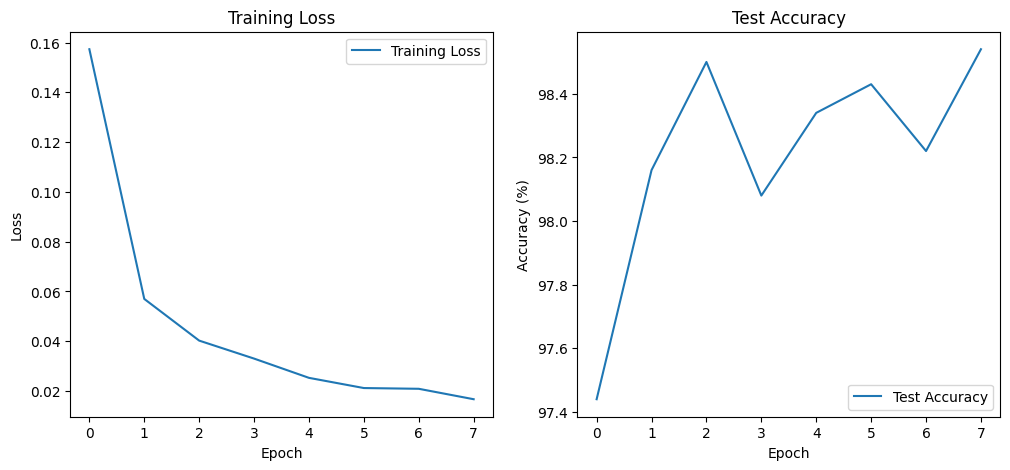

In [32]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Linear(6272, 1000)
        self.fc2 = nn.Linear(1000, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


# Hyperparameters
num_epochs = 8
batch_size = 64
learning_rate = 0.001

train_loader, test_loader = load_dataset(batch_size)
model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss_list, acc_list = train(model, train_loader, test_loader, criterion, optimizer, num_epochs, device)
plot_metrics(loss_list, acc_list)

In [33]:
test(model, test_loader, device)

98.54

In [34]:
get_model_parameters(model)

6283842

### Small Model: 3199106 parameters, 2(Conv2d + MaxPool2d) + 2fc, test accuracy 99.2%

Epoch [1/8], Average Loss: 0.1177
Epoch [2/8], Average Loss: 0.0389
Epoch [3/8], Average Loss: 0.0279
Epoch [4/8], Average Loss: 0.0222
Epoch [5/8], Average Loss: 0.0179
Epoch [6/8], Average Loss: 0.0191
Epoch [7/8], Average Loss: 0.0117
Epoch [8/8], Average Loss: 0.0144


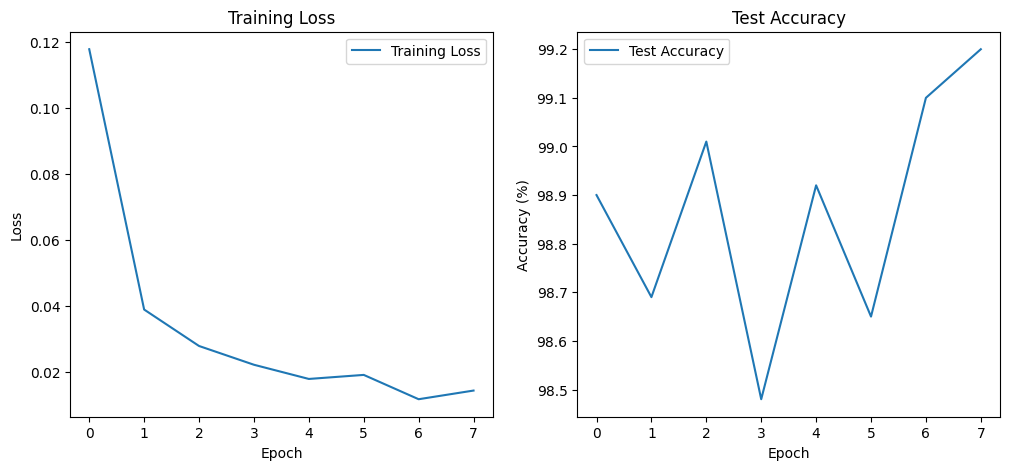

In [29]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNetSmall(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNetSmall, self).__init__()
        # First convolutional layer
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2), # Input channels, output channels, kernel size
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) # Pooling layer
        
        # Second convolutional layer
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2), # Input from layer1, increasing channels
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) # Pooling layer

        self.fc1 = nn.Linear(3136, 1000) # Adjusted input size
        self.fc2 = nn.Linear(1000, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
# Hyperparameters
num_epochs = 8
batch_size = 64
learning_rate = 0.001

train_loader, test_loader = load_dataset(batch_size)
model = ConvNetSmall().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss_list, acc_list = train(model, train_loader, test_loader, criterion, optimizer, num_epochs, device)
plot_metrics(loss_list, acc_list)

In [30]:
test(model, test_loader, device)

99.2

In [31]:
get_model_parameters(model)

3199106

### Use MEC to help decide the architecture: 266054 parameters, Conv2d + MaxPool2d + 2fc,  test accuracy 98.29%

#### Information of MNIST

Since the convolution layer and pooling layer process the input while the fully connected layers (MLP) make final classification. Therefore we can use the MEC of the MLP to estimate the size of the CNN model. 

MNIST dataset contains 70000 instance (considering both the train dataset and the test dataset) and there are 10 classes, contributing for about 232388 bits. Then ideally, we only need a model of MEC about 232388 to fit the MNIST dataset.

In [16]:
len(train_dataset) + len(test_dataset)

70000

In [18]:
import numpy as np
info = 0
for class_label in range(10):
    occurrence = len(train_dataset.targets[train_dataset.targets == class_label]) + len(test_dataset.targets[test_dataset.targets == class_label])
    info += -(occurrence * np.log2(occurrence / 70000))
    
print(info)

232388.59177823894


#### Analyze the previous model

For the baseline model, the compression ratio of the Conv2d is $\frac{1}{32}$ and of the pooing is $\frac{28\times28}{14\times14}=4$. The MLP has a MEC about $(6272 + 1)\times 1000 + 1000 \times 10=62830000$ bits. This is much larger than the information of MNIST dataset. 

This explains why the smaller model achieves comparable results as the baseline model as all these models are larger than they needs to be.

Let $y, x$ be the size of hidden layers, we have $10x+x\times(y-1)>=232388$. We have pairs such as $x=224, y=1176$. In addition, we increase the compression ratio of the Conv2d to be $\frac{1}{6}$ while maintaining that of the pooling layer. Note that in this computation we ignored the compression ratio.

This model turns out to achieve comparable results as the larger models, meaning that the parameters in these large models are not necessary.

Epoch [1/8], Average Loss: 0.2314
Epoch [2/8], Average Loss: 0.0913
Epoch [3/8], Average Loss: 0.0723
Epoch [4/8], Average Loss: 0.0619
Epoch [5/8], Average Loss: 0.0535
Epoch [6/8], Average Loss: 0.0470
Epoch [7/8], Average Loss: 0.0424
Epoch [8/8], Average Loss: 0.0393


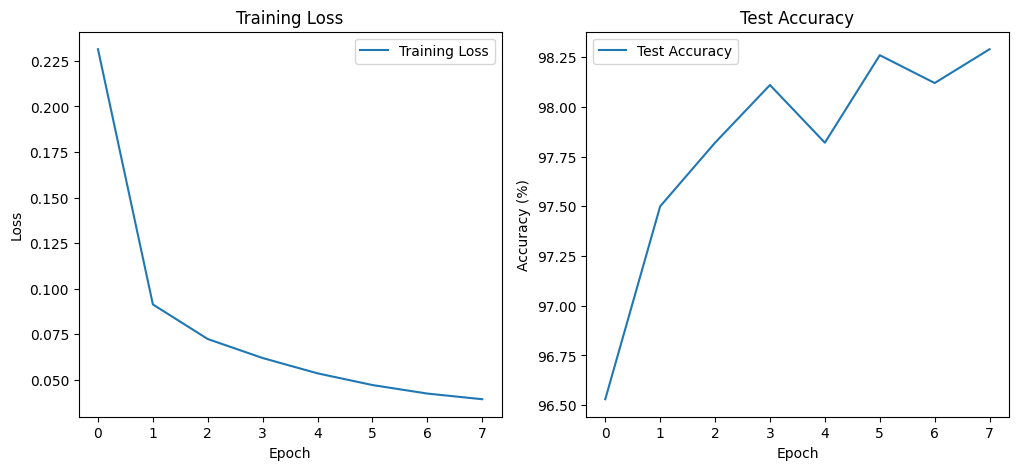

In [20]:
class ConvNetOpt(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNetOpt, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Linear(1176, 224)
        self.fc2 = nn.Linear(224, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


# Hyperparameters
num_epochs = 8
batch_size = 64
learning_rate = 0.001

train_loader, test_loader = load_dataset(batch_size)
model = ConvNetOpt().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss_list, acc_list = train(model, train_loader, test_loader, criterion, optimizer, num_epochs, device)
plot_metrics(loss_list, acc_list)

In [22]:
test(model, test_loader, device)

98.29

In [24]:
get_model_parameters(model)

266054